<a href="https://colab.research.google.com/github/decoz/mlclass/blob/master/ch9_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense

# GAN

GAN은 생산적 적대 신경망 ( Generative Adversarial Network ) 의 약자로서 다양한 딥 페이크 기술에 쓰인다. GAN은  진짜와 그럴듯이 보이는 가짜를 만들어내는  네트워크로서 경쟁 학습이라는 독특한 시스템을 사용한다. 

GAN에 필요한 요소는 다음과 같다. 

- 진짜 데이터 
- 가짜 데이터를 만드는 모방 신경망
- 생성된 데이터 진위 판별 신경망

GAN은 다음과 같은 과정을 세번의 과정을 통해 학습된다. 

1. 모방 신경망(generator)를 통해 가짜 데이터 생성 
2. 진짜 데이터와 가짜 데이터를 번갈아 진위판별망(discriminator)에 입력해 학습
3. 랜덤 데이터로 모방 신경망 학습 








## 가장 단순한 GAN 구성

이런 구조의 네트워크를 어떻게 구성해야 하는지 처음에는 언뜻 이해가 가지 안을 것이다.  이제부터 이것이 어떻게 작동하는 지 원리를 알아보기 위해 가장 단순한 형태의 GAN을 하나를 만들어보도록 하겠다. 





### 1. 모방할 데이터 모델

다음은 흔한 numpy 의 sin 관계를 갖는 데이터 생성코드이다.  


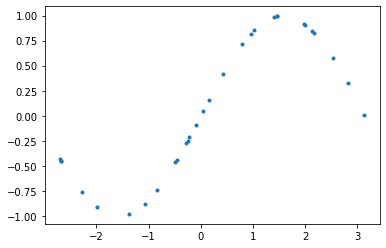

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

x = (np.random.rand(30,1) - 0.5)*2.*np.pi # -pi ~ pi 까지 랜덤 생성
y = np.sin(x)    # y 는 x의 sin 함수 값

plt.plot(x,y,'.')
plt.show()


이제 위의 곡선이 우리가 모방하고 싶은 x,y 의 모임이라고 가정해보자. 이제 위의 곡선을 통해 모방 데이터를 생성하는 함수를 하나 정의하도록 하겠다.  아래의 함수 real 은 n개의 sin 에 위치한 점을 생성한다. 

주의할 점은 x 와 sin(x)가 같이 2차원 배열로 리턴되고 y 는 real 데이터를 의미하는 1 값으로 채워진다.  이것은 점 -> 진짜 or 가짜 판별을 위한 판별망에 학습데이터로 사용하기 위해서이다. 



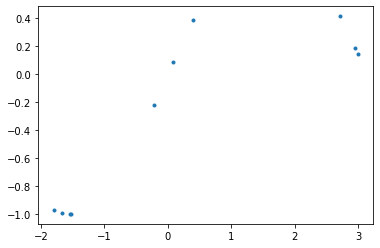

[[-1.54819053 -0.9997445 ]
 [-0.22187881 -0.22006277]
 [ 2.71719855  0.41176871]
 [-1.52790384 -0.99908026]
 [ 0.39789552  0.38747913]
 [ 0.08338022  0.08328364]
 [ 2.95848948  0.18208175]
 [-1.80079085 -0.97366764]
 [ 2.9990761   0.1420346 ]
 [-1.66671929 -0.99540292]] [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [6]:
def real(n):   
    x = (np.random.rand(n,1) - 0.5)*2.*np.pi
    x = np.hstack((x, np.sin(x)))
    y = np.ones((n, 1))
    return x,y

x,y = real(10)
plt.plot(x[:,0], x[:,1],'.')
plt.show()
print(x,y)

### 2. 모방 신경망 (generator)

 우리의 목표는 이 데이터를 만들어주는 모방 신경망(generator)이다.  이 망에서 입력은 어디까지나 데이터를 생성하기 위한 시드값일 뿐이며 타겟 데이터와는 연관이 없는 랜덤값을 사용한다. 요컨데 우리가 원하는 것은 

"아무 값이나 넣어도 sin 곡선안에 있는 한점을 만들어주는 신경망 "

이다. 점을 만들어주기 때문에 출력은 2차원이여야 하며 입력은 일종의 더미 데이터이기 때문에 임의의 크기로 자유롭게 구성할 수 있다. 




In [8]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

# keras 모델 리셋
tf.keras.backend.clear_session()


x_dim = 3 # 더미 입력값 크기

# 모방 신경망 정의 
generator = Sequential() 
generator.add(Dense(15, activation='relu', input_dim=x_dim))
generator.add(Dense(2, activation='linear'))
 
    


이제 generator 를 이용해 모방 데이터를 생성하는 함수를 정의하도록 하겠다.  create_x 는 n개의 랜덤한 더미 입력값을 만들어주며, fake 는 generator 를 이용해 모방 데이터를 생성한다. 


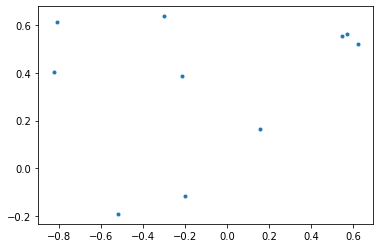

In [11]:

def create_x(x_dim,n):
    return np.random.randn(n,x_dim)

def fake(x_dim, n, generator):
    x = create_x(x_dim, n)   
    y = generator.predict(x)       
    return y,np.zeros((n,1))

x,y = fake(x_dim, 10, generator)
plt.plot(x[:,0], x[:,1],'.')

위의 코드를 실행해보면 생성된 초기 모방데이터가 얼마나 엉망인지 알 수 있다. 
<br><br>
### 3. 판별 신경망 (discriminator) 

판별 신경망은 실제데이터 및 모방데이터를 입력으로 받은 후에 어느쪽이 진짜인지를 판별하는 기능을 갖는다. 위의 예제의 경우 가장 단순한 형태의 신경망으로도 이것이 구성 가능하다. 

이때 입력은 x,y 의 좌표값이므로 2 가 되며 출력은 이것이 진짜인지 아닌지 0,1 로 판별하는 단일 값을 갖는다. 



In [12]:
discriminator = Sequential()
discriminator.add(Dense(25, activation='relu', input_dim=2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### 4. 전체 망(GAN) 과 학습 과정

GAN은 모방신경망 -> 판별 신경망을 순차적으로 이어서 생성한다. 



In [13]:
discriminator.trainable = False
model = Sequential()
model.add(generator)    
model.add(discriminator)
model.compile(loss='binary_crossentropy', optimizer='adam')



이제 단일 학습이 어떤 식으로 이루어지는지 간단히 살펴보도록 하겠다. 



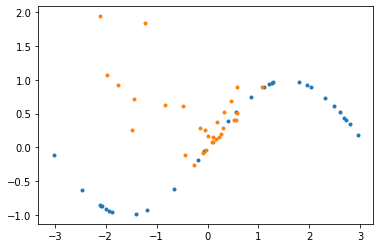

In [21]:
n = 30

# 실제와 모방 데이터 생성
rx,ry = real(n)
fx,fy = fake(x_dim, n, generator)

plt.plot(rx[:,0],rx[:,1],'.')
plt.plot(fx[:,0],fx[:,1],'.')

# 판별망 학습
discriminator.train_on_batch(rx,ry)
discriminator.train_on_batch(fx[:,:2],fy)
    
x = create_x(x_dim,n)
y = np.ones((n,1))

# 전체 신경망 학습 = 모방신경망 학습
model.train_on_batch(x,y)
plt.show()

판별망 학습 -> 모방 신경망 학습으로 반복된다. 전체 학습시 위에서 discriminator.trainable = False 코드를 통해 판별망의 학습을 꺼두었으므로 개별 학습이 아닌 전체 학습에서는 판별신경망이 아닌 모방신경망의 학습이 이뤄지게 된다. 

이제 이것을 반복함으로서 모방 데이터의 변화를 보도록 하겠다. 

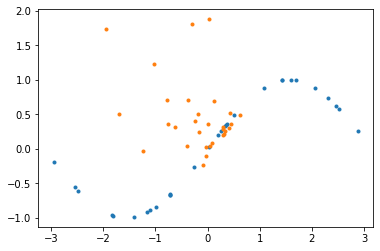

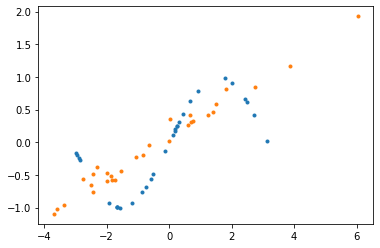

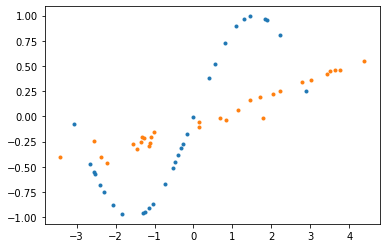

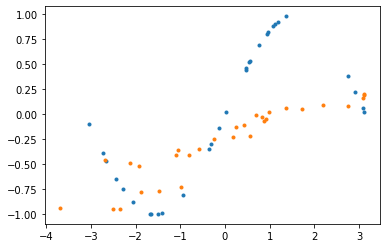

KeyboardInterrupt: ignored

In [22]:
epochs , n = 10000, 30

for i in range(epochs):
  # 실제와 모방 데이터 생성
  rx,ry = real(n)
  fx,fy = fake(x_dim, n, generator)

  # 시각화는 1000 번마다 
  if i % 1000 == 0 : 
    plt.plot(rx[:,0],rx[:,1],'.')
    plt.plot(fx[:,0],fx[:,1],'.')
    plt.show()


  # 판별망 학습
  discriminator.train_on_batch(rx,ry)
  discriminator.train_on_batch(fx[:,:2],fy)
      
  x = create_x(x_dim,n)
  y = np.ones((n,1))

  # 전체 신경망 학습 = 모방신경망 학습
  model.train_on_batch(x,y)
